# Copula by Ratio Estimation

For a copula denity $c(F_1(x_1),F_2(x_2))=\frac{h(x_1,x_2)}{f_1(x_1)\cdot f_2(x_2)}$, we can reinterpret this as a ratio $\frac{p(x_1,x_2)}{q(x_1,x_2)}=r(x_1,x_2) \in \mathbb{R}^{+}$.

With this insight, let us use density ratio estimation methods to recover the copula density $c$. We will train a classifier given samples from $p$ and $q$, depending on a parameterised function $r_\theta:\mathcal{X}\rightarrow\mathbb{R}^{+}$ to optimise the logistic loss:
$$
\mathcal{L}(\boldsymbol{\theta})=-\mathbb{E}_{\mathbf{x}_1 \sim p} \log \left(\frac{r\left(\mathbf{x}_1 ; \boldsymbol{\theta}\right)}{1+r\left(\mathbf{x}_1 ; \boldsymbol{\theta}\right)}\right)-\mathbb{E}_{\mathbf{x}_2 \sim q} \log \left(\frac{1}{1+r\left(\mathbf{x}_2 ; \boldsymbol{\theta}\right)}\right)
$$

### $r_\theta$ as a linear regression of $(x_1,x_2,x_1^{2},x_2^2,x_1\cdot x_2)$

Let $c(u,v)=\frac{N_2(x_1,x_2)}{N(x_1)\cdot N(x_2)}$ and $f_1(x),f_2(x)=N(x)$

c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\tight_bbox.py:71: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\tight_bbox.py:72: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\patches.py:743: RuntimeWarning: invalid value encountered in scalar add
  x1 = self.convert_xunits(self._x0 + self._width)
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\patches.py:744: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)


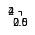

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(0,0))
plt.plot([1,2,3,4])
plt.show()

c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


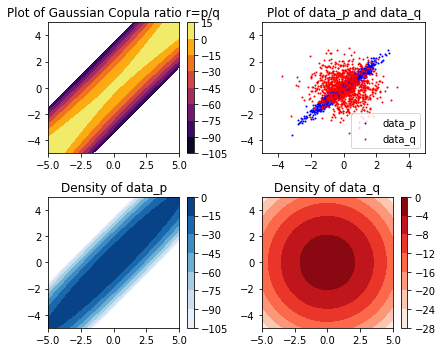

In [2]:

import torch
import numpy as np


# Gaussian helper functions
def pdf_std_normal(input):
  return torch.distributions.normal.Normal(loc = 0, scale = 1).log_prob(input).exp()

def inverse_std_normal(input):
  return torch.distributions.normal.Normal(loc = 0, scale = 1).icdf(input)

def bvn_density(rho, x, y, shift = 0.0, scale = 1.0):

   mean = torch.tensor([shift, shift])
   covariance_matrix = torch.tensor([[scale, rho], [rho, scale]])
   multivariate_normal = torch.distributions.MultivariateNormal(mean, covariance_matrix)

   l = len(x)
   input = torch.cat([x.reshape(l, 1), y.reshape(l, 1)], dim=1)

   return multivariate_normal.log_prob(input).exp()

def GC_density(rho, x, y):
  '''
  Gaussian Copula pdf on data scale
  '''
  f_1 = pdf_std_normal(x).log()
  f_2 = pdf_std_normal(y).log()
  low = f_1 + f_2

  up = bvn_density(rho = rho, x = x, y = y).log()

  return (up - low).exp()

N = 1000
data_p = torch.distributions.MultivariateNormal(torch.tensor([0.0, 0.0]), torch.tensor([[1.0, 0.97], [0.97, 1.0]])).sample((N,))
data_q = torch.distributions.MultivariateNormal(torch.tensor([0.0, 0.0]), torch.tensor([[1.0, 0], [0, 1.0]])).sample((N,))

## Plots of Gaussian Copula (the ratio r), and samples from p and q
xline = torch.linspace(-5, 5, 100)
yline = torch.linspace(-5, 5., 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
uvinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

px = GC_density(rho = 0.97, x = uvinput[:,0], y = uvinput[:,1])

fig, axs = plt.subplots(2, 2, figsize=(6, 5))  

# Plot of Gaussian Copula ratio r=p/q
contour_plot = axs[0, 0].contourf(xgrid.numpy(), ygrid.numpy(), px.reshape(100, 100).log(), cmap='inferno')
fig.colorbar(contour_plot, ax=axs[0, 0]) 
axs[0, 0].set_title('Plot of Gaussian Copula ratio r=p/q')

# Plot of data_p and data_q
axs[0, 1].scatter(data_p[:, 0], data_p[:, 1], s=1, color='blue', label='data_p')
axs[0, 1].scatter(data_q[:, 0], data_q[:, 1], s=1, color='red', label='data_q')
axs[0, 1].set_xlim([-5, 5])  
axs[0, 1].set_ylim([-5, 5])  
axs[0, 1].set_title('Plot of data_p and data_q')
axs[0, 1].legend()

# Density plot of data_p
density_p = bvn_density(rho = 0.97, x = uvinput[:,0], y = uvinput[:,1]).log()
density_p_plot = axs[1, 0].contourf(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Blues')
fig.colorbar(density_p_plot, ax=axs[1, 0])
axs[1, 0].set_title('Density of data_p')

# Density plot of data_q
density_q = bvn_density(rho = 0, x = uvinput[:,0], y = uvinput[:,1]).log()
density_q_plot = axs[1, 1].contourf(xgrid.numpy(), ygrid.numpy(), density_q.reshape(100, 100), cmap='Reds')
fig.colorbar(density_q_plot, ax=axs[1, 1])
axs[1, 1].set_title('Density of data_q')

plt.tight_layout()
plt.show()

c:\Users\u1819911\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:1038: RuntimeWarning: divide by zero encountered in log
  return np.log(probas_)


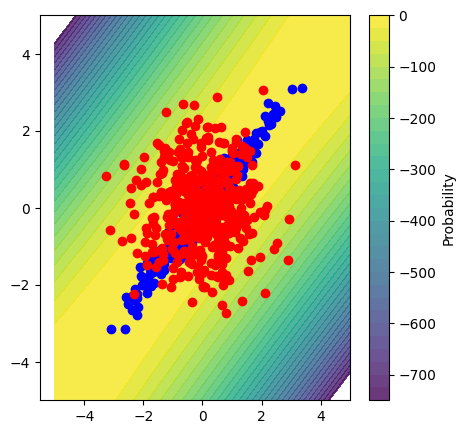

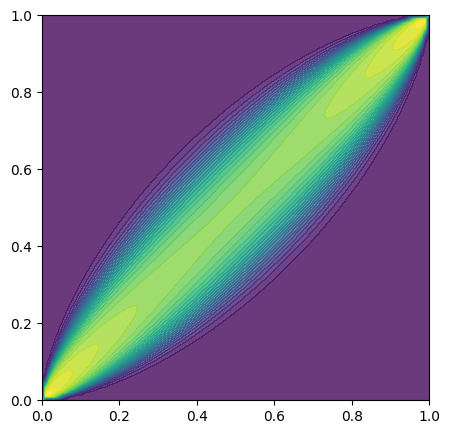

In [61]:
# QDA to classify data_p and data_q with sklearn
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = torch.cat([data_p, data_q], dim=0).numpy()
y = np.concatenate([np.zeros(N), np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict_proba(X_test)[:,0]
#plot the decision boundary
h = .05 # step size in the mesh
xline = torch.linspace(-5, 5, 100)
yline = torch.linspace(-5, 5, 100)
xx, yy = np.meshgrid(xline,yline )

#plot
Z = qda.predict_log_proba(np.c_[xx.ravel(), yy.ravel()])[:,0]
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

contour = ax.contourf(xx, yy, Z, alpha=0.8, levels=30)
fig.colorbar(contour, ax=ax, label='Probability')
ax.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='blue', label='data_p')
ax.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='red', label='data_q')
ax.set_xlim([-5.5, 5])
ax.set_ylim([-5, 5])
#add a colorbar

#now plot on 0-1 copula spoace through norm.cdf
#start with 0-1 data mehsgrid then mad it through inv cdf
xline = torch.linspace(0.0000001, 0.9999999, 100)
yline = torch.linspace(0.0000001, 0.9999999, 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
uvinput = torch.cat([inverse_std_normal(xgrid.reshape(-1, 1)), inverse_std_normal(ygrid.reshape(-1, 1))], dim=1)

#now compute qda on this data
X = uvinput.numpy()
Z = qda.predict_proba(X)[:,0]
Z = Z.reshape(xgrid.shape)

#plot on 0-1 copula space
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# have more levels to make the plot more clear

ax.contourf(xgrid.numpy(), ygrid.numpy(), Z, alpha=0.8, levels=30)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.show()

In [34]:
qda.predict_proba(X)[:,0].shape

(10000,)

In [3]:
from sklearn.preprocessing import PolynomialFeatures

def log_ratio(theta, data, degree=None):
  '''
  Vectorized version of a regression r = theta_0 + theta_1*x1 + theta_2*x2 + theta_3*x1^2 + theta_4*x2^2 + theta_5*x1*x2
  theta : regression coefficients (n_theta*1)
  data = [x1, x2] : list of n tuplets (n*dim)
  '''
  x1 = data[:,0]
  x2 = data[:,1]
  if degree is not None:
    x_expanded = PolynomialFeatures(degree).fit_transform(data)
    return torch.matmul(torch.tensor(x_expanded).float(), theta)
  else:
    return theta[0] + theta[1]*x1 + theta[2]*x2 + theta[3]*(x1)**2 +theta[4]*(x2)**2 + theta[5]*x1*x2

def Logistic_loss(r_p,r_q):
    '''
    Vectorised version of the logistic loss function from TRE eq(1)
    '''
    return -(r_p /(1+r_p)).log() - (1/(1+r_q)).log() 

In [17]:
import torch.optim as optim
import scipy.stats as scs
from tqdm import tqdm

theta = torch.tensor(torch.ones(6), requires_grad=True) # d=2: 6 parameters, d=3: 10 parameters, d=4: 15 parameters, d=5: 21 parameters
rho = 0.97
data_p = torch.tensor(scs.multivariate_normal.rvs(mean = [0,0], cov = [[1,rho],[rho,1]], size = 1000))
data_q = torch.tensor(np.random.permutation(data_p))
data_p.requires_grad = False
data_q.requires_grad = False

theta_history = []
loss_history = []
learning_rate = 0.12
basis_degree = 2
optimizer = optim.Adam([theta], lr=learning_rate)

for t in tqdm(range(10000)):
    optimizer.zero_grad()
    data_q_perm = torch.tensor([np.random.permutation(data_q[:,0]),np.random.permutation(data_q[:,1])]).T
    #if t % 1000 == 0:
        #with torch.no_grad():
            #print("Iteration: ", t, "Loss: ", loss.item())
    r_p = log_ratio(theta = theta, data = data_p, degree=basis_degree).exp()
    r_q = log_ratio(theta = theta, data = data_q_perm,  degree=basis_degree).exp()
    loss = Logistic_loss(r_p,r_q).mean() 
    loss.backward()
    optimizer.step()
    theta_history.append(theta.clone().detach().numpy())
    loss_history.append(loss.clone().detach().item())

print(theta)

C:\Users\david\AppData\Local\Temp\ipykernel_24556\3994696406.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(torch.ones(6), requires_grad=True) # d=2: 6 parameters, d=3: 10 parameters, d=4: 15 parameters, d=5: 21 parameters
100%|██████████| 10000/10000 [00:18<00:00, 550.80it/s]

tensor([ 1.3525e+00, -6.2312e-02,  9.7071e-03, -8.1220e+00,  1.6911e+01,
        -8.2804e+00], requires_grad=True)


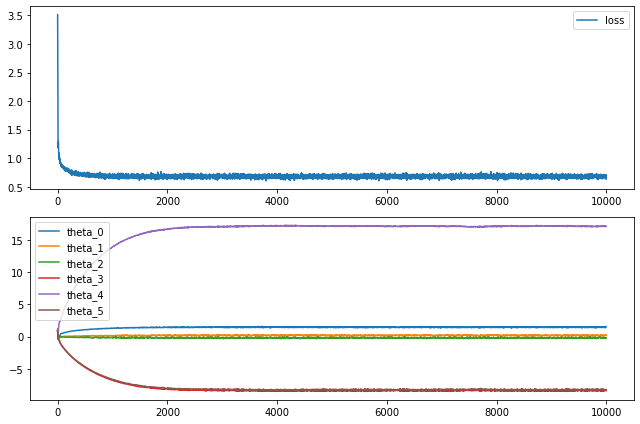

theta:  tensor([ 1.5539,  0.2159, -0.2064, -8.3674, 17.0563, -8.2367],
       requires_grad=True)


In [5]:
fig, axs = plt.subplots(2, 1, figsize=(9, 6))

# Plot loss history in the first subplot
axs[0].plot(loss_history, label='loss')
axs[0].legend()

# Plot theta history in the second subplot
axs[1].plot(theta_history, label='theta')
axs[1].legend(['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5'])

plt.tight_layout()
plt.show()
print('theta: ', theta) # tensor([ 1.3524, -0.0822,  0.1119, -6.8440, -6.5374, 13.7761]

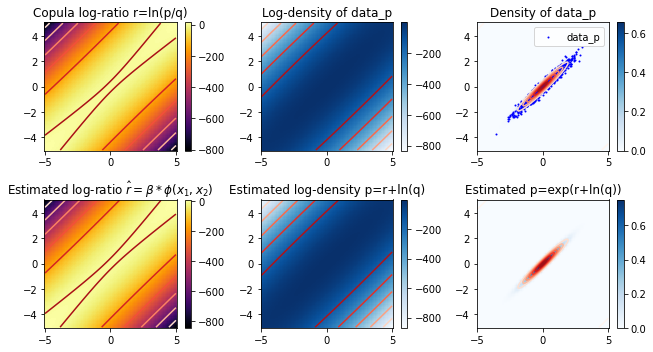

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(9, 5))  

# Plot of Gaussian Copula ratio r=p/q
px = scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,rho],[rho,1]])-scs.norm.logpdf(x = uvinput[:,0])-scs.norm.logpdf(x = uvinput[:,1])
contour_plot = axs[0,0].pcolormesh(xgrid.numpy(), ygrid.numpy(), px.reshape(100, 100), cmap='inferno')
fig.colorbar(contour_plot, ax=axs[0,0]) 
axs[0,0].contour(xgrid.numpy(), ygrid.numpy(), px.reshape(100, 100), cmap='Reds')
axs[0,0].set_title('Copula log-ratio r=ln(p/q)')

# Plot of ratio 
ratio = log_ratio(theta = theta, data = uvinput, degree=basis_degree).detach().numpy()
ratio_plot = axs[1,0].pcolormesh(xgrid.numpy(), ygrid.numpy(), ratio.reshape(100, 100), cmap='inferno')
fig.colorbar(ratio_plot, ax=axs[1,0])
axs[1,0].contour(xgrid.numpy(), ygrid.numpy(), ratio.reshape(100, 100), cmap='Reds')
axs[1,0].set_title(r'Estimated log-ratio $\hat{r}=\beta *\phi(x_1,x_2)$')

# Plot of joint density of data_p
density_p = scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,rho],[rho,1]])
density_p_plot = axs[0,1].pcolormesh(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Blues')
fig.colorbar(density_p_plot, ax=axs[0,1])
axs[0,1].contour(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Reds')
axs[0,1].set_title('Log-density of data_p')

# Plot of estimated log p=r+log q
ratio_joint = ratio.reshape(100, 100)+scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0],[0,1]]).reshape(100, 100)
density_ratio_joint = axs[1,1].pcolormesh(xgrid.numpy(), ygrid.numpy(), ratio_joint, cmap='Blues')
fig.colorbar(density_ratio_joint, ax=axs[1,1])
axs[1,1].contour(xgrid.numpy(), ygrid.numpy(), ratio_joint, cmap='Reds')
axs[1,1].set_title('Estimated log-density p=r+ln(q)')

# Plot of datap
density_p = scs.multivariate_normal.pdf(x = uvinput, mean = [0,0], cov = [[1,rho],[rho,1]])
density_p_plot = axs[0,2].pcolormesh(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Blues')
fig.colorbar(density_p_plot, ax=axs[0,2])
axs[0,2].contour(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Reds')
axs[0,2].scatter(data_p[:, 0], data_p[:, 1], s=1, color='blue', label='data_p')
axs[0,2].legend()
axs[0,2].set_title('Density of data_p')

# Plot of estimated p=exp(r)*q
ratio_joint = ratio.reshape(100, 100)+scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0],[0,1]]).reshape(100, 100)
density_ratio_joint = axs[1,2].pcolormesh(xgrid.numpy(), ygrid.numpy(), np.exp(ratio_joint), cmap='Blues')
fig.colorbar(density_ratio_joint, ax=axs[1,2])
axs[1,2].contour(xgrid.numpy(), ygrid.numpy(), np.exp(ratio_joint), cmap='Reds')
axs[1,2].set_title('Estimated p=exp(r+ln(q))')




plt.tight_layout()
plt.show()


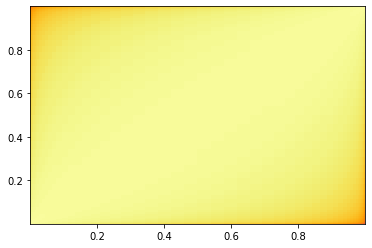

In [7]:
# Plot of ratio 
ratio = log_ratio(theta = theta, data = uvinput, degree=basis_degree).detach().numpy()
plt.pcolormesh(scs.norm.cdf(xgrid.numpy()), scs.norm.cdf(ygrid.numpy()), ratio.reshape(100, 100), cmap='inferno')
fig.colorbar(ratio_plot, ax=axs[1,0])


### Other simple 2D examples


#### Clayton

c:\Users\u1819911\Anaconda3\lib\site-packages\clayton\rng\base.py:332: RuntimeWarning: overflow encountered in divide
  geninv = self._generator_inv(samplegamma/samplefrailty)
c:\Users\u1819911\Anaconda3\lib\site-packages\clayton\rng\base.py:332: RuntimeWarning: divide by zero encountered in divide
  geninv = self._generator_inv(samplegamma/samplefrailty)
c:\Users\u1819911\Anaconda3\lib\site-packages\clayton\rng\archimedean.py:71: RuntimeWarning: overflow encountered in multiply
  return np.power((1.0 + self.theta*var), -1/self.theta)


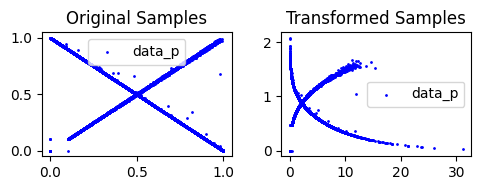

In [12]:
from clayton.rng.archimedean import Clayton
from scipy.stats import gamma, weibull_min

# [0-1] scale samples from 2 Clayton copulas
cla1 = Clayton(theta=310, n_samples=5000)
samples_1 = cla1.sample_unimargin()
cla2 = Clayton(theta=-0.999, n_samples=5000)
samples_2 = cla2.sample_unimargin()

samples = np.concatenate((samples_1, samples_2))

# Transform the samples
transformed_samples_1 = gamma(a=1,scale=3).ppf(samples[:,0])
transformed_samples_2 = weibull_min(c=3).ppf(samples[:,1])

# Concatenate the transformed samples

fig, axs = plt.subplots(1, 2, figsize=(5, 2))
axs[0].scatter(samples[:,0], samples[:,1], s=1, color='blue', label='data_p')
axs[0].set_title('Original Samples')
axs[0].legend()
axs[1].scatter(transformed_samples_1, transformed_samples_2, s=1, color='blue', label='data_p')
axs[1].set_title('Transformed Samples')
axs[1].legend()
plt.tight_layout()
plt.show()

#copula plot


In [14]:
import torch.optim as optim
import scipy.stats as scs

theta = torch.tensor(torch.ones(6), requires_grad=True)
data_p = torch.tensor(np.column_stack((transformed_samples_1,transformed_samples_2)))
data_q = torch.tensor(np.column_stack((np.random.permutation(transformed_samples_1),np.random.permutation(transformed_samples_2))))
data_p.requires_grad = False
data_q.requires_grad = False

theta_history = []
loss_history = []
learning_rate = 0.005
optimizer = optim.Adam([theta], lr=learning_rate)

for t in range(50000):
    data_q = torch.tensor(np.column_stack((np.random.permutation(transformed_samples_1),np.random.permutation(transformed_samples_2)))).requires_grad_(False)
    if t % 1000 == 0:
        with torch.no_grad():
            print("Iteration: ", t, "Loss: ", loss, "Theta: ", theta)
    r_p = log_ratio(theta = theta, data = data_p).exp()
    r_q = log_ratio(theta = theta, data = data_q).exp()
    loss = Logistic_loss(r_q,r_p).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    theta_history.append(theta.clone().detach().numpy())
    loss_history.append(loss.clone().detach().item())



C:\Users\u1819911\AppData\Local\Temp\ipykernel_2184\3322489566.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(torch.ones(6), requires_grad=True)


Iteration:  0 Loss:  tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>) Theta:  tensor([1., 1., 1., 1., 1., 1.], requires_grad=True)
Iteration:  1000 Loss:  tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>) Theta:  tensor([nan, nan, nan, nan, nan, nan], requires_grad=True)


KeyboardInterrupt: 

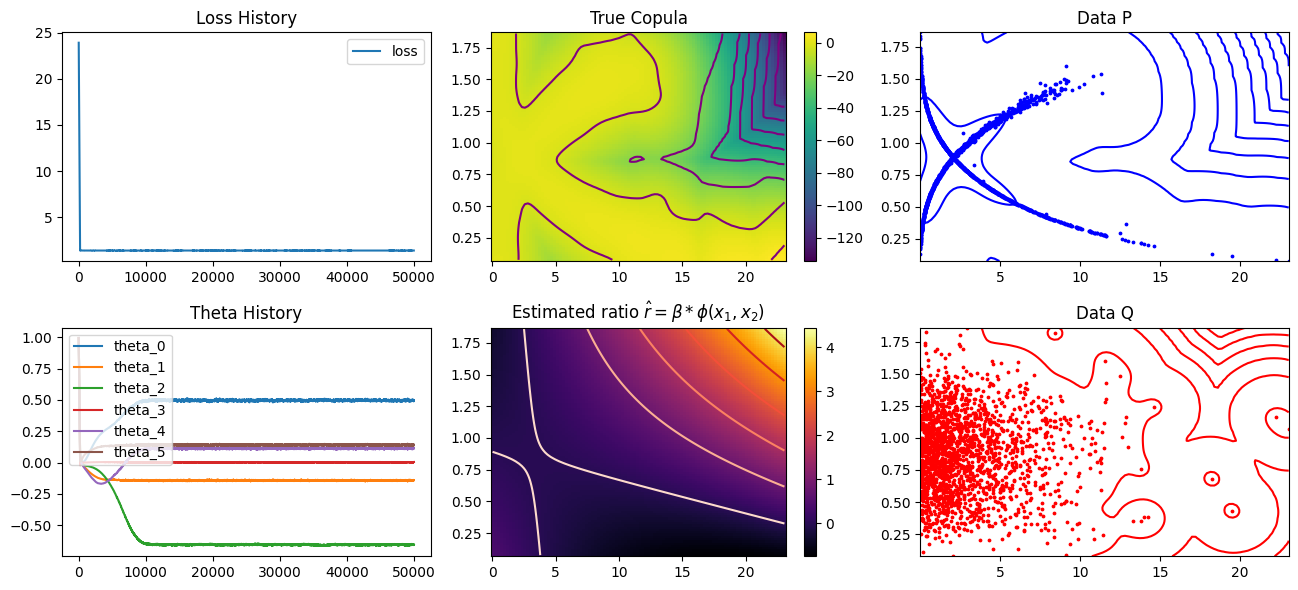

In [1060]:
from scipy.stats import gaussian_kde
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

# KDEs of the transformed samples
kde = gaussian_kde(np.vstack([transformed_samples_1, transformed_samples_2]))
kde_p = gaussian_kde(data_p.T)
kde_q = gaussian_kde(data_q.T)
x_grid = np.linspace(min(transformed_samples_1), max(transformed_samples_1), 100)
y_grid = np.linspace(min(transformed_samples_2), max(transformed_samples_2), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z_p = np.reshape(kde_p(np.vstack([X.ravel(), Y.ravel()])), X.shape)
Z_q = np.reshape(kde_q(np.vstack([X.ravel(), Y.ravel()])), X.shape)

fig, axs = plt.subplots(2, 3, figsize=(13, 6))

# Plot loss history in the first cell
axs[0, 0].plot(loss_history, label='loss')
axs[0, 0].legend(['loss'])
axs[0, 0].set_title('Loss History')

# Plot theta history in the second cell
axs[1, 0].plot(theta_history, label='theta')
axs[1, 0].legend(['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5'])
axs[1, 0].set_title('Theta History')

# Plot true copula in the third cell
Z1 = np.log(kde(np.vstack([X.ravel(), Y.ravel()])))
Z2 = gamma(a=1,scale=3).logpdf(np.vstack([X.ravel(), Y.ravel()])[0]) + weibull_min(c=3).logpdf(np.vstack([X.ravel(), Y.ravel()])[1])
Z = np.reshape(Z1 - Z2, X.shape)
pcm = axs[0, 1].pcolormesh(X, Y, Z,  rasterized=True)
fig.colorbar(pcm, ax=axs[0, 1])
axs[0, 1].contour(X, Y, Z_p/Z_q,norm=LogNorm(), colors='purple')
axs[0, 1].set_title('True Copula')

# Plot of ratio in the fourth cell
ratio = log_ratio(theta, data=torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T)).detach().numpy()
cfm = axs[1, 1].pcolormesh(x_grid, y_grid, ratio.reshape(100, 100), cmap='inferno')
fig.colorbar(cfm, ax=axs[1, 1])
axs[1, 1].contour(X, Y, ratio.reshape(100, 100), cmap='Reds')
axs[1, 1].set_title(r'Estimated ratio $\hat{r}=\beta *\phi(x_1,x_2)$')

# Plot data_p and data_q in the fifth and sixth cells
axs[0, 2].scatter(data_p[:,0],data_p[:,1], s=3, color='blue', label='data_p')
axs[0, 2].contour(X, Y, Z_p,norm=LogNorm(), colors='blue')
axs[0, 2].set_title('Data P')
axs[1, 2].scatter(data_q[:,0],data_q[:,1], s=3, color='red', label='data_q')
axs[1, 2].contour(X, Y, Z_q,norm=LogNorm(), colors='red')
axs[1, 2].set_title('Data Q')

plt.tight_layout()
plt.show()



### MLP for classification

In [4]:
import torch
import torch.optim as optim
import scipy.stats as scs
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split

class MLP(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.02):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.Dropout(dropout_p), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU())
        self.output_layer = nn.Linear(hidden_size, output_size)
        # or simple
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layer1 = nn.Linear(hidden_size, hidden_size)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output_layer(x)
        return x

    def forward_simple(self,x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer1(x))
        x = F.relu(self.hidden_layer2(x))
        x = self.output_layer(x)
        return x
    
    def train_simple(self, data_p, data_q, steps=2000, learning_rate=0.005, weight_decay=0.01, permute=False, verbose=True, patience=500):
        self.data_p = data_p
        self.data_q = data_q
        param_history = []
        loss_history = []
        optimizer = optim.Adam(self.parameters(), lr=learning_rate,  weight_decay=weight_decay)
        #scheduler = StepLR(optimizer, step_size=5000, gamma=0.95)
        # Define your learning rate scheduler
        #lambda1 = lambda epoch: epoch // 30
        #lambda2 = lambda epoch: 0.95 ** epoch
        #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])
        
        # Split data into a training set and a validation set
        dataset = TensorDataset(data_p, data_q)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=128)
        
        # Initialize the early stopping variables
        best_val_loss = float('inf')
        patience_counter = 0

        # Train 
        loss = 1 
        for t in tqdm(range(steps)):
            for batch_p, batch_q in train_dataloader:
                optimizer.zero_grad()
                r_p = self.forward_simple(data_p.float()).exp()
                r_q = self.forward_simple(data_q.float()).exp()
                loss = Logistic_loss(r_p,r_q).mean() 
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_value_(self.parameters(), clip_value=5.0)
                optimizer.step()

                # Evaluate the model on the validation set
                with torch.no_grad():
                    val_loss = 0
                    for val_p, val_q in val_dataloader:
                        r_p_val = self.forward_simple(val_p.float()).exp()
                        r_q_val = self.forward_simple(val_q.float()).exp()
                        val_loss += Logistic_loss(r_p_val,r_q_val).mean().item()
                    val_loss /= len(val_dataloader)

                # Check if we need to save the model and if we need to stop training
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print("Early stopping")
                        self.param_history = param_history
                        self.loss_history = loss_history
                        return

            with torch.no_grad():    
                loss_history.append(loss.clone().detach().item()) 
                if t % (steps/50) == 0:
                    if permute: # Permute data_q
                        data_q = torch.tensor([np.random.permutation(data_q[:,0]),np.random.permutation(data_q[:,1])]).T
                    param_history.append(np.concatenate([t.view(-1).numpy() for t in self.state_dict().values()]))
                    if verbose:
                        print("Iteration: ", t, "Loss: ", loss)
                        print("MLP parameters: ", param_history[-1][:5])
                    '''# Manually decrease learning rate based on the last 10 entries of loss_history having increased
                    last_losses = loss_history[-20:]
                    increases = sum(x < y for x, y in zip(last_losses, last_losses[1:]))
                    if increases>10:  # Count how many times the loss has increased
                        print("Decreasing learning rate!")
                        for param_group in optimizer.param_groups:
                            param_group['lr'] *= 0.95  # Decrease learning rate 
                            if param_group['lr']<10e-6:
                                print("Learning rate too low, stopping training!")
                                break'''
        self.param_history = param_history
        self.loss_history = loss_history

    def train(self, data_p, data_q, steps=2000, learning_rate=0.005, verbose=True):
        self.data_p = data_p
        self.data_q = data_q
        param_history = []
        loss_history = []
        # Define the optimizer (Stochastic Gradient Descent)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate,  weight_decay=0.01)
        #scheduler = StepLR(optimizer, step_size=5000, gamma=0.95)
        # Define your learning rate scheduler
        #lambda1 = lambda epoch: epoch // 30
        #lambda2 = lambda epoch: 0.95 ** epoch
        #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])
        
        # Train the model
        loss = 1 
        for t in range(steps):
            '''if abs(loss-2*torch.tensor(0.5).log())<10e-10:
                print('OPSIE DAISY WE HAD A PROBLEM')
                for param in self.parameters():
                    noise = 10e-5*torch.randn_like(param) # generate noise with the same shape as param
                    param.data.add_(noise)  # add the noise to the parameter'''
            optimizer.zero_grad()
            r_p = self.forward(data_p.float()).exp()
            r_q = self.forward(data_q.float()).exp()
            loss = Logistic_loss(r_p,r_q).mean() 
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_value_(self.parameters(), clip_value=5.0)
            optimizer.step()

            with torch.no_grad():    
                loss_history.append(loss.clone().detach().item()) 
                if t % (steps/100) == 0:
                    #permute data_q
                    data_q = torch.tensor([np.random.permutation(data_q[:,0]),np.random.permutation(data_q[:,1])]).T
                    param_history.append(np.concatenate([t.view(-1).numpy() for t in self.state_dict().values()]))
                    if verbose:
                        print("Iteration: ", t, "Loss: ", loss)
                        print("MLP parameters: ", param_history[-1][:5])
                    # Manually decrease learning rate based on the last 10 entries of loss_history having increased
                    last_losses = loss_history[-20:]
                    increases = sum(x < y for x, y in zip(last_losses, last_losses[1:]))
                    if increases>10:  # Count how many times the loss has increased
                        print("Decreasing learning rate!")
                        for param_group in optimizer.param_groups:
                            param_group['lr'] *= 0.97  # Decrease learning rate by 10%
                            if param_group['lr']<10e-6:
                                print("Learning rate too low, stopping training!")
                                break
        self.param_history = param_history
        self.loss_history = loss_history
                    
    def ratio_for_plot(self,simple=False):
        data_scale_p=np.linspace(self.data_p.min(),data_p.max(),100)
        data_scale_q=np.linspace(self.data_q.min(),data_q.max(),100)
        X, Y = np.meshgrid(data_scale_p, data_scale_q)
        with torch.no_grad():
            if simple:
                ratio = self.forward_simple(torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T).float()).detach().numpy()
            else:
                ratio = self.forward(torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T).float()).detach().numpy()
        return ratio.reshape(100, 100)
    
    def diagnostics(self, loss_lim = None):
        ''' 
        Plot loss history and theta history
        loss_lim: to have [-k:] to plot the last k iterations
        '''
        fig, axs = plt.subplots(1, 2, figsize=(9, 3))
        # Plot loss history in the first cell
        if loss_lim is not None:
            axs[0].plot(self.loss_history[-loss_lim:], label='loss')
        else:
            axs[0].plot(self.loss_history, label='loss')
        axs[0].legend(['loss'])
        axs[0].set_title('Loss History')
        # Plot theta history in the second cell
        #axs[1].plot(self.param_history, label='theta')
        #axs[1].set_title('Theta History')
        plt.tight_layout()
        plt.show()



#### Gaussian Copula

In [11]:
gaussian_model = MLP(2, 10, 1)
data_p_norm = torch.tensor(scs.multivariate_normal.rvs(mean = [0,0], cov = [[1,0.97],[0.97,1]], size = 5000))
data_q_norm = torch.tensor([np.random.permutation(data_p_norm[:,0]),np.random.permutation(data_p_norm[:,1])]).T
gaussian_model.train_simple(data_p_norm, data_q_norm, steps=50, learning_rate=0.0002, weight_decay=0.0005, permute=True, verbose=True, patience=5000)


  2%|▏         | 1/50 [00:01<00:56,  1.16s/it]

Iteration:  0 Loss:  tensor(1.3821, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


  4%|▍         | 2/50 [00:02<00:54,  1.13s/it]

Iteration:  1 Loss:  tensor(1.3793, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


  6%|▌         | 3/50 [00:03<00:49,  1.05s/it]

Iteration:  2 Loss:  tensor(1.3763, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


  8%|▊         | 4/50 [00:04<00:43,  1.06it/s]

Iteration:  3 Loss:  tensor(1.3730, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 10%|█         | 5/50 [00:04<00:39,  1.13it/s]

Iteration:  4 Loss:  tensor(1.3688, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 12%|█▏        | 6/50 [00:05<00:37,  1.17it/s]

Iteration:  5 Loss:  tensor(1.3627, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 14%|█▍        | 7/50 [00:06<00:36,  1.18it/s]

Iteration:  6 Loss:  tensor(1.3541, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 16%|█▌        | 8/50 [00:07<00:35,  1.19it/s]

Iteration:  7 Loss:  tensor(1.3427, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 18%|█▊        | 9/50 [00:08<00:34,  1.20it/s]

Iteration:  8 Loss:  tensor(1.3282, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 20%|██        | 10/50 [00:08<00:32,  1.24it/s]

Iteration:  9 Loss:  tensor(1.3141, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 22%|██▏       | 11/50 [00:09<00:29,  1.30it/s]

Iteration:  10 Loss:  tensor(1.2955, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 24%|██▍       | 12/50 [00:10<00:28,  1.34it/s]

Iteration:  11 Loss:  tensor(1.2750, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 26%|██▌       | 13/50 [00:10<00:27,  1.34it/s]

Iteration:  12 Loss:  tensor(1.2542, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 28%|██▊       | 14/50 [00:11<00:27,  1.33it/s]

Iteration:  13 Loss:  tensor(1.2283, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 30%|███       | 15/50 [00:12<00:26,  1.33it/s]

Iteration:  14 Loss:  tensor(1.2023, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 32%|███▏      | 16/50 [00:13<00:24,  1.37it/s]

Iteration:  15 Loss:  tensor(1.1764, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 34%|███▍      | 17/50 [00:13<00:23,  1.39it/s]

Iteration:  16 Loss:  tensor(1.1454, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 36%|███▌      | 18/50 [00:14<00:22,  1.42it/s]

Iteration:  17 Loss:  tensor(1.1240, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 38%|███▊      | 19/50 [00:15<00:21,  1.42it/s]

Iteration:  18 Loss:  tensor(1.0921, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 40%|████      | 20/50 [00:15<00:21,  1.38it/s]

Iteration:  19 Loss:  tensor(1.0686, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 42%|████▏     | 21/50 [00:16<00:20,  1.40it/s]

Iteration:  20 Loss:  tensor(1.0407, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 44%|████▍     | 22/50 [00:17<00:19,  1.41it/s]

Iteration:  21 Loss:  tensor(1.0113, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 46%|████▌     | 23/50 [00:18<00:18,  1.43it/s]

Iteration:  22 Loss:  tensor(0.9810, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 48%|████▊     | 24/50 [00:18<00:18,  1.44it/s]

Iteration:  23 Loss:  tensor(0.9486, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 50%|█████     | 25/50 [00:19<00:17,  1.46it/s]

Iteration:  24 Loss:  tensor(0.9281, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 52%|█████▏    | 26/50 [00:20<00:16,  1.46it/s]

Iteration:  25 Loss:  tensor(0.9005, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 54%|█████▍    | 27/50 [00:20<00:16,  1.42it/s]

Iteration:  26 Loss:  tensor(0.8933, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 56%|█████▌    | 28/50 [00:21<00:15,  1.40it/s]

Iteration:  27 Loss:  tensor(0.8731, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 58%|█████▊    | 29/50 [00:22<00:15,  1.39it/s]

Iteration:  28 Loss:  tensor(0.8568, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 60%|██████    | 30/50 [00:22<00:14,  1.42it/s]

Iteration:  29 Loss:  tensor(0.8393, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 62%|██████▏   | 31/50 [00:23<00:13,  1.44it/s]

Iteration:  30 Loss:  tensor(0.8119, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 64%|██████▍   | 32/50 [00:24<00:12,  1.44it/s]

Iteration:  31 Loss:  tensor(0.8145, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 66%|██████▌   | 33/50 [00:25<00:11,  1.43it/s]

Iteration:  32 Loss:  tensor(0.7981, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 68%|██████▊   | 34/50 [00:25<00:11,  1.41it/s]

Iteration:  33 Loss:  tensor(0.7913, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 70%|███████   | 35/50 [00:26<00:10,  1.44it/s]

Iteration:  34 Loss:  tensor(0.7561, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 72%|███████▏  | 36/50 [00:27<00:09,  1.45it/s]

Iteration:  35 Loss:  tensor(0.7599, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 74%|███████▍  | 37/50 [00:27<00:08,  1.47it/s]

Iteration:  36 Loss:  tensor(0.7528, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 76%|███████▌  | 38/50 [00:28<00:08,  1.47it/s]

Iteration:  37 Loss:  tensor(0.7643, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 78%|███████▊  | 39/50 [00:29<00:07,  1.48it/s]

Iteration:  38 Loss:  tensor(0.7432, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 80%|████████  | 40/50 [00:29<00:06,  1.49it/s]

Iteration:  39 Loss:  tensor(0.7272, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 82%|████████▏ | 41/50 [00:30<00:06,  1.45it/s]

Iteration:  40 Loss:  tensor(0.7380, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 84%|████████▍ | 42/50 [00:31<00:05,  1.46it/s]

Iteration:  41 Loss:  tensor(0.7469, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 86%|████████▌ | 43/50 [00:31<00:04,  1.47it/s]

Iteration:  42 Loss:  tensor(0.7201, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 88%|████████▊ | 44/50 [00:32<00:04,  1.48it/s]

Iteration:  43 Loss:  tensor(0.7222, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 90%|█████████ | 45/50 [00:33<00:03,  1.49it/s]

Iteration:  44 Loss:  tensor(0.7137, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 92%|█████████▏| 46/50 [00:33<00:02,  1.50it/s]

Iteration:  45 Loss:  tensor(0.7351, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 94%|█████████▍| 47/50 [00:34<00:02,  1.50it/s]

Iteration:  46 Loss:  tensor(0.7214, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 96%|█████████▌| 48/50 [00:35<00:01,  1.46it/s]

Iteration:  47 Loss:  tensor(0.7202, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


 98%|█████████▊| 49/50 [00:35<00:00,  1.48it/s]

Iteration:  48 Loss:  tensor(0.7098, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]

Iteration:  49 Loss:  tensor(0.7216, grad_fn=<MeanBackward0>)
MLP parameters:  [-0.35363987  0.45212239 -0.27525845  0.36717266 -0.66651875]


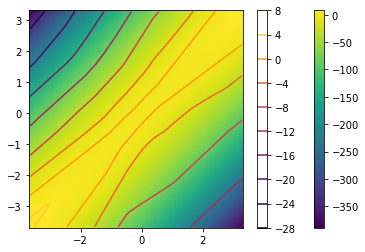

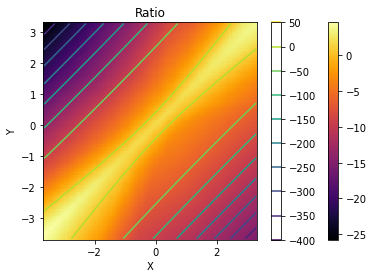

In [12]:
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

# Parameters
mu = torch.zeros(2)  # mean
cov = torch.tensor([[1,0.97],[0.97,1]])  # covariance matrix, identity matrix indicates independence

# Create grid and multivariate normal
x = torch.linspace(gaussian_model.data_p.min(),gaussian_model.data_p.max(),100)
y = x
X, Y = torch.meshgrid(x, y)
pos = torch.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
with torch.no_grad():
    ratio = gaussian_model.forward_simple(torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T).float()).detach().numpy()
rv = MultivariateNormal(mu, cov)
rv_ind = MultivariateNormal(torch.zeros(2), torch.eye(2))
# Make a 2D contour plot
plt.pcolormesh(X.numpy(), Y.numpy(),(rv.log_prob(pos)).numpy()-(rv_ind.log_prob(pos)).numpy(), cmap='viridis')
plt.colorbar()
plt.contour(X.numpy(), Y.numpy(),ratio.reshape(100,100), cmap='inferno')
plt.colorbar()
plt.show()
with torch.no_grad():
    ratio = gaussian_model.forward_simple(torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T).float()).detach().numpy()
plt.pcolormesh(X.numpy(), Y.numpy(),ratio.reshape(100,100), cmap='inferno')
plt.colorbar()

plt.contour(X.numpy(), Y.numpy(),(rv.log_prob(pos)).numpy()-(rv_ind.log_prob(pos)).numpy(), cmap='viridis')

plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.title('Ratio')
plt.show()

NameError: name 'params_history_mlp_transposed' is not defined

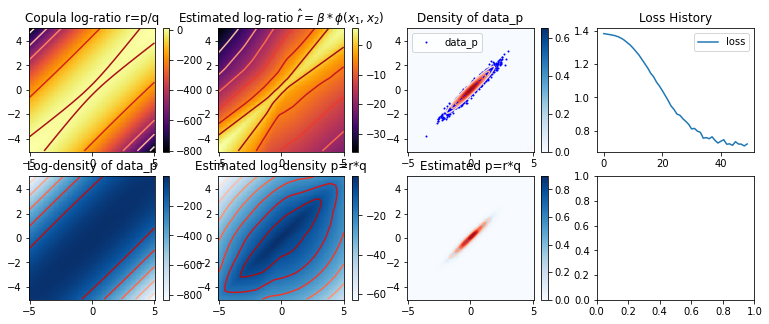

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(13, 5))  

xline = torch.linspace(-5, 5, 100)
yline = torch.linspace(-5, 5., 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
uvinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

# Plot of Gaussian Copula ratio r=p/q
px = scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0.97],[0.97,1]])-scs.norm.logpdf(x = uvinput[:,0])-scs.norm.logpdf(x = uvinput[:,1])
contour_plot = axs[0,0].pcolormesh(xgrid.numpy(), ygrid.numpy(), px.reshape(100, 100), cmap='inferno')
fig.colorbar(contour_plot, ax=axs[0,0]) 
axs[0,0].contour(xgrid.numpy(), ygrid.numpy(), px.reshape(100, 100), cmap='Reds')
axs[0,0].set_title('Copula log-ratio r=p/q')

# Plot of ratio 
with torch.no_grad():
    ratio = gaussian_model.forward_simple(torch.tensor(np.vstack([xgrid.ravel(), ygrid.ravel()]).T).float()).detach().numpy()
ratio_plot = axs[0,1].pcolormesh(xgrid.numpy(), ygrid.numpy(), ratio.reshape(100, 100), cmap='inferno')
fig.colorbar(ratio_plot, ax=axs[0,1])
axs[0,1].contour(xgrid.numpy(), ygrid.numpy(), ratio.reshape(100, 100), cmap='Reds')
axs[0,1].set_title(r'Estimated log-ratio $\hat{r}=\beta *\phi(x_1,x_2)$')

# Plot of joint density of data_p
density_p = scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0.97],[0.97,1]])
density_p_plot = axs[1,0].pcolormesh(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Blues')
fig.colorbar(density_p_plot, ax=axs[1,0])
axs[1,0].contour(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Reds')
axs[1,0].set_title('Log-density of data_p')

# Plot of estimated p=exp(r)*q
ratio_joint = ratio.reshape(100, 100)+scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0],[0,1]]).reshape(100, 100)
density_ratio_joint = axs[1,1].pcolormesh(xgrid.numpy(), ygrid.numpy(), ratio_joint, cmap='Blues')
fig.colorbar(density_ratio_joint, ax=axs[1,1])
axs[1,1].contour(xgrid.numpy(), ygrid.numpy(), ratio_joint, cmap='Reds')
axs[1,1].set_title('Estimated log-density p=r*q')

# Plot of datap
density_p = scs.multivariate_normal.pdf(x = uvinput, mean = [0,0], cov = [[1,0.97],[0.97,1]])
density_p_plot = axs[0,2].pcolormesh(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Blues')
fig.colorbar(density_p_plot, ax=axs[0,2])
axs[0,2].contour(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Reds')
axs[0,2].scatter(data_p[:, 0], data_p[:, 1], s=1, color='blue', label='data_p')
axs[0,2].legend()
axs[0,2].set_title('Density of data_p')

# Plot of estimated p=exp(r)*q
ratio_joint = ratio.reshape(100, 100)+scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0],[0,1]]).reshape(100, 100)
density_ratio_joint = axs[1,2].pcolormesh(xgrid.numpy(), ygrid.numpy(), np.exp(ratio_joint), cmap='Blues')
fig.colorbar(density_ratio_joint, ax=axs[1,2])
axs[1,2].contour(xgrid.numpy(), ygrid.numpy(), np.exp(ratio_joint), cmap='Reds')
axs[1,2].set_title('Estimated p=r*q')

# Plot loss history in the first cell
#axs[0, 0].plot(loss_history_mlp[-500:], label='loss')
axs[0, 3].plot(gaussian_model.loss_history, label='loss')
axs[0, 3].legend(['loss'])
axs[0, 3].set_title('Loss History')

# Plot MLP parameters history in the second cell
params_subset = params_history_mlp_transposed[:50]
for i, param_history in enumerate(params_subset):
    axs[1, 3].plot(param_history, label=f'param_{i}')
axs[1, 3].set_title('MLP Parameters History')

plt.tight_layout()
plt.show()


##### Clayton Copula with Gamma and Weinbull marginals

In [16]:
mlp_Clayton = MLP(2, 100, 1)
data_p = torch.tensor(np.column_stack((transformed_samples_1,transformed_samples_2)))
data_q = torch.tensor([np.random.permutation(data_p[:,0]),np.random.permutation(data_p[:,1])]).T
data_p.requires_grad = False
data_q.requires_grad = False
mlp_Clayton.train_simple(data_p, data_q, steps=100, learning_rate=0.0002, weight_decay=0.0005, permute=True, verbose=True, patience=5000)
'''
gaussian_model = MLP(2, 100, 1)
data_p_norm = torch.tensor(scs.multivariate_normal.rvs(mean = [0,0], cov = [[1,0.97],[0.97,1]], size = 5000))
data_q_norm = torch.tensor([np.random.permutation(data_p[:,0]),np.random.permutation(data_p[:,1])]).T
gaussian_model.train_simple(data_p_norm, data_q_norm, steps=100, learning_rate=0.0002, weight_decay=0.0005, permute=True, verbose=True, patience=5000)'''


Iteration:  0 Loss:  tensor(1.3773, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38767117  0.54253846 -0.28150395 -0.13815254  0.14328933]
Iteration:  2 Loss:  tensor(1.2796, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38767117  0.54253846 -0.28150395 -0.13815254  0.14328933]
Iteration:  4 Loss:  tensor(1.0360, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38767117  0.54253846 -0.28150395 -0.13815254  0.14328933]
Iteration:  6 Loss:  tensor(0.8527, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38767117  0.54253846 -0.28150395 -0.13815254  0.14328933]
Iteration:  8 Loss:  tensor(0.7540, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38767117  0.54253846 -0.28150395 -0.13815254  0.14328933]
Iteration:  10 Loss:  tensor(0.6740, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38767117  0.54253846 -0.28150395 -0.13815254  0.14328933]
Iteration:  12 Loss:  tensor(0.6317, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38767117  0.54253846 -0.28150395 -0.13815254  0.14328933]
Iteration:  14 Los

'\ngaussian_model = MLP(2, 100, 1)\ndata_p_norm = torch.tensor(scs.multivariate_normal.rvs(mean = [0,0], cov = [[1,0.97],[0.97,1]], size = 5000))\ndata_q_norm = torch.tensor([np.random.permutation(data_p[:,0]),np.random.permutation(data_p[:,1])]).T\ngaussian_model.train_simple(data_p_norm, data_q_norm, steps=100, learning_rate=0.0002, weight_decay=0.0005, permute=True, verbose=True, patience=5000)'

C:\Users\u1819911\AppData\Local\Temp\ipykernel_2184\4028532053.py:37: RuntimeWarning: divide by zero encountered in log
  Z1 = np.log(kde(np.vstack([X.ravel(), Y.ravel()])))
C:\Users\u1819911\AppData\Local\Temp\ipykernel_2184\4028532053.py:58: UserWarning: Log scale: values of z <= 0 have been masked
  axs[0, 2].contour(X, Y, Z_p,norm=LogNorm(), colors='blue')
C:\Users\u1819911\AppData\Local\Temp\ipykernel_2184\4028532053.py:61: UserWarning: Log scale: values of z <= 0 have been masked
  axs[1, 2].contour(X, Y, Z_q,norm=LogNorm(), colors='red')


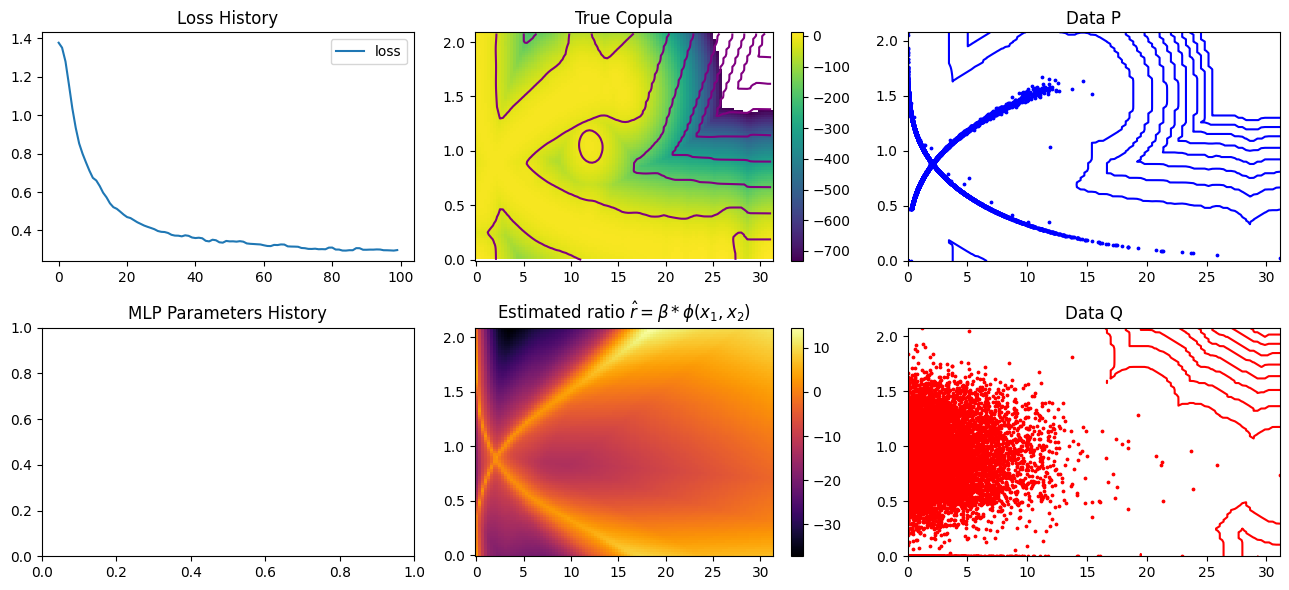

In [19]:
from scipy.stats import gaussian_kde
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

# KDEs of the transformed samples
kde = gaussian_kde(np.vstack([transformed_samples_1, transformed_samples_2]))
kde_p = gaussian_kde(data_p.T)
kde_q = gaussian_kde(data_q.T)
x_grid = np.linspace(min(transformed_samples_1), max(transformed_samples_1), 100)
y_grid = np.linspace(min(transformed_samples_2), max(transformed_samples_2), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z_p = np.reshape(kde_p(np.vstack([X.ravel(), Y.ravel()])), X.shape)
Z_q = np.reshape(kde_q(np.vstack([X.ravel(), Y.ravel()])), X.shape)

fig, axs = plt.subplots(2, 3, figsize=(13, 6))

# Plot loss history in the first cell
#axs[0, 0].plot(loss_history_mlp[-500:], label='loss')
axs[0, 0].plot(mlp_Clayton.loss_history, label='loss')
axs[0, 0].legend(['loss'])
axs[0, 0].set_title('Loss History')

# Plot MLP parameters history in the second cell
params_history_mlp_transposed = np.array(mlp_Clayton.param_history).T # Transpose the array so that each row corresponds to a different parameter
#for i, param_history in enumerate(params_history_mlp_transposed):
#    axs[1, 0].plot(param_history, label=f'param_{i}')
axs[1, 0].set_title('MLP Parameters History')

# Plot true copula in the third cell
kde_bw = 0.1
kde = gaussian_kde(np.vstack([transformed_samples_1, transformed_samples_2]), bw_method=kde_bw)
kde_p = gaussian_kde(data_p.T, bw_method=kde_bw)
kde_q = gaussian_kde(data_q.T, bw_method=kde_bw)
x_grid = np.linspace(min(transformed_samples_1), max(transformed_samples_1), 100)
y_grid = np.linspace(min(transformed_samples_2), max(transformed_samples_2), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z1 = np.log(kde(np.vstack([X.ravel(), Y.ravel()])))
Z2 = gamma(a=1,scale=3).logpdf(np.vstack([X.ravel(), Y.ravel()])[0]) + weibull_min(c=3).logpdf(np.vstack([X.ravel(), Y.ravel()])[1])
Z = np.reshape(Z1 - Z2, X.shape)
pcm = axs[0, 1].pcolormesh(X, Y, Z,  rasterized=True)
fig.colorbar(pcm, ax=axs[0, 1])
axs[0, 1].contour(X, Y, Z_p/Z_q,norm=LogNorm(), colors='purple')
axs[0, 1].set_title('True Copula')

# Plot of ratio in the fourth cell
with torch.no_grad():
    ratio = mlp_Clayton.forward_simple(torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T).float()).detach().numpy()
#ratio = log_ratio(theta, data=torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T)).detach().numpy()
cfm = axs[1, 1].pcolormesh(X, Y, ratio.reshape(100,100), cmap='inferno')
fig.colorbar(cfm, ax=axs[1, 1])
axs[1, 1].set_title(r'Estimated ratio $\hat{r}=\beta *\phi(x_1,x_2)$')


# Plot data_p and data_q in the fifth and sixth cells
Z_p = np.reshape(kde_p(np.vstack([X.ravel(), Y.ravel()])), X.shape)
Z_q = np.reshape(kde_q(np.vstack([X.ravel(), Y.ravel()])), X.shape)
axs[0, 2].scatter(data_p[:,0],data_p[:,1], s=3, color='blue', label='data_p')
axs[0, 2].contour(X, Y, Z_p,norm=LogNorm(), colors='blue')
axs[0, 2].set_title('Data P')
axs[1, 2].scatter(data_q[:,0],data_q[:,1], s=3, color='red', label='data_q')
axs[1, 2].contour(X, Y, Z_q,norm=LogNorm(), colors='red')
axs[1, 2].set_title('Data Q')


plt.tight_layout()
plt.show()

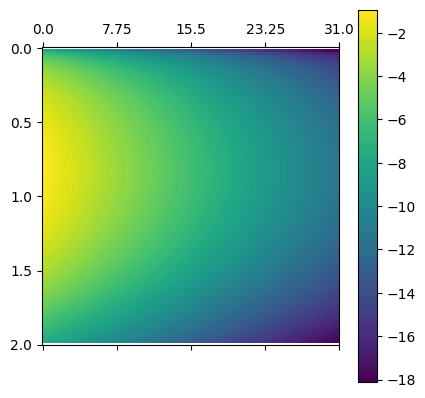

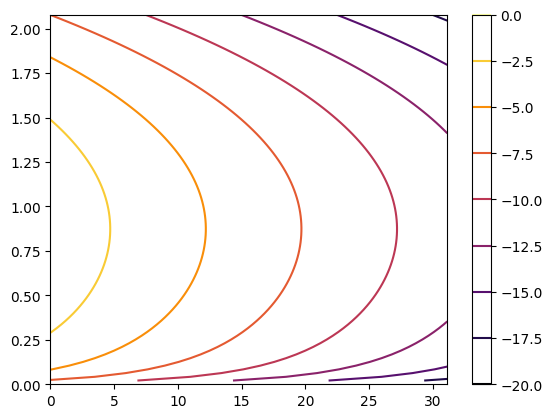

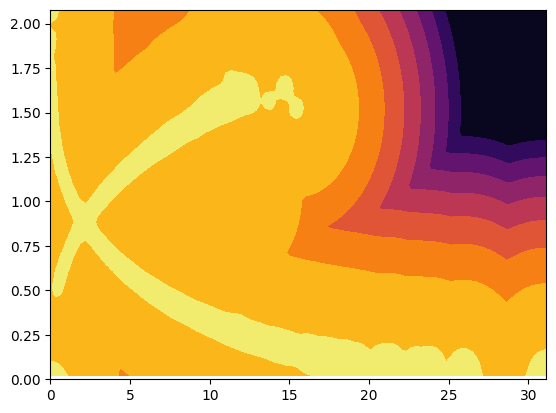

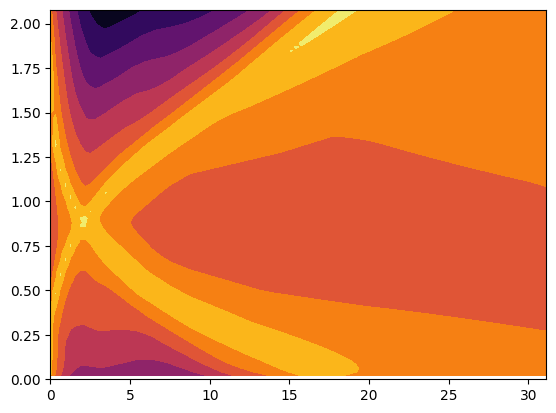

In [99]:
Z_r = ratio.reshape(100,100)
# Transform the samples
x_pdf = gamma(a=1,scale=3).logpdf(X)
y_pdf = weibull_min(c=3).logpdf(Y)
q_logpdf = x_pdf+y_pdf
plt.matshow(q_logpdf)
plt.colorbar()
plt.xticks(np.linspace(0,100,5), np.linspace(0,31,5))
plt.yticks(np.linspace(0,100,5), np.linspace(0,2,5))
plt.show()

plt.contour(X, Y, q_logpdf, cmap='inferno')
plt.colorbar()
plt.show()

Z_p_log = Z_p
Z_p_log[Z_p_log==0] = 4.94065646e-350
Z_p_log = np.log(Z_p_log)

plt.contourf(X, Y, Z_p_log-q_logpdf, cmap='inferno')
plt.show()

plt.contourf(X, Y, Z_r+q_logpdf, cmap='inferno')
plt.show()


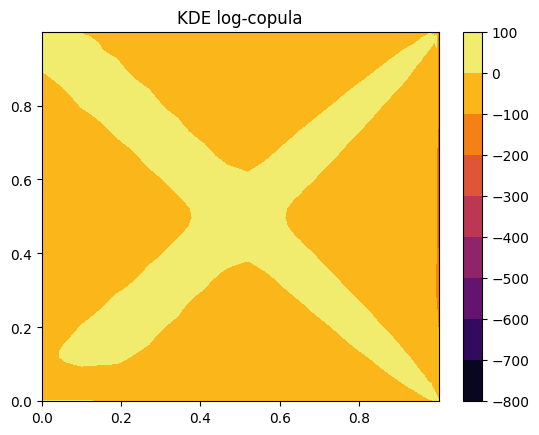

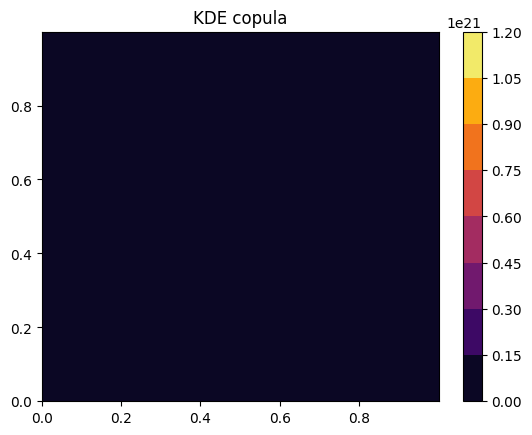

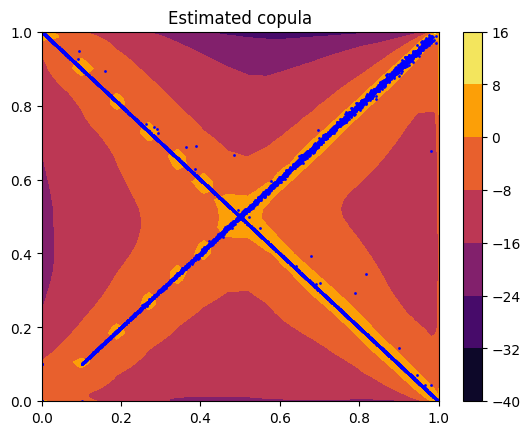

In [117]:
# KDEs of the transformed samples
kde = gaussian_kde(np.vstack([transformed_samples_1, transformed_samples_2]))
kde_p = gaussian_kde(data_p.T)
kde_q = gaussian_kde(data_q.T)
x_grid = np.linspace(min(transformed_samples_1), max(transformed_samples_1), 100)
y_grid = np.linspace(min(transformed_samples_2), max(transformed_samples_2), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z_p = np.reshape(kde_p(np.vstack([X.ravel(), Y.ravel()])), X.shape)
Z_q = np.reshape(kde_q(np.vstack([X.ravel(), Y.ravel()])), X.shape)

U_x = gamma(a=1,scale=3).cdf(X)
U_y = weibull_min(c=3).cdf(Y)
plt.contourf(U_x, U_y,Z_p_log-q_logpdf, cmap='inferno')
plt.title('KDE log-copula')
plt.colorbar()
plt.show()


plt.contourf(U_x, U_y,Z_p/Z_q, cmap='inferno')
plt.title('KDE copula')
plt.colorbar()
plt.show()

plt.contourf(U_x, U_y,Z_r, cmap='inferno')
plt.title('Estimated copula')
plt.xlim(0,1)
plt.ylim(0,1)
plt.colorbar()
plt.scatter(samples[:,0], samples[:,1], s=1, color='blue', label='data_p')

plt.show()


# Fun example

In [5]:
from PIL import Image
import numpy as np
from scipy.special import logsumexp

image_path = "bayes_image.png" 
image = Image.open(image_path)
bw_image = image.convert("L")
image_array = abs(np.array(bw_image)[:,:562]/255 -1)
im_flat = image_array.flatten()
true_p = np.exp(np.log(im_flat)-logsumexp(np.log(im_flat))).reshape(562,562)
plt.matshow(true_p,cmap='gray')

import matplotlib.image as mpimg

img=mpimg.imread('emily1.jpg')
# convert to grayscale
img = np.mean(img, axis=2)
img = np.log(1e-2 +img / 6.0)
# rescale to 0,1
true_p = (img - np.min(img)) / (np.max(img) - np.min(img))
#true_p = np.abs(img - 1.0)
# rescale to be562,562
true_p = true_p[0:562,0:562]
true_p = true_p/np.sum(true_p)
plt.matshow(true_p,cmap='gray')


C:\Users\david\AppData\Local\Temp\ipykernel_23672\2250829146.py:10: RuntimeWarning: divide by zero encountered in log
  true_p = np.exp(np.log(im_flat)-logsumexp(np.log(im_flat))).reshape(562,562)


ValueError: cannot reshape array of size 41800 into shape (562,562)

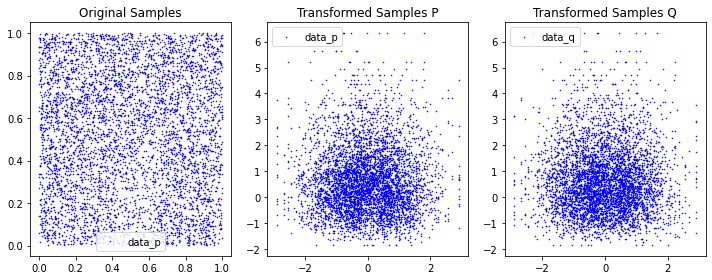

In [28]:
# Sample from the true copula
import scipy.stats as scs

sample_idx = np.random.choice(range(315844), size=5000,p=true_p.flatten(), replace=False)
sample_x = np.clip(sample_idx%562,1,562)/562
sample_y = abs(sample_idx//562 - 562)/562

# Transform the samples
transformed_samples_1 = scs.norm(loc=0,scale=1).ppf(sample_x)
transformed_samples_2 = scs.gumbel_r().ppf(sample_y)

# Concatenate the transformed samples

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].scatter(sample_x, sample_y, s=0.3, color='blue', label='data_p')
axs[0].set_title('Original Samples')
axs[0].legend()
axs[1].scatter(transformed_samples_1, transformed_samples_2, s=0.3, color='blue', label='data_p')
axs[1].set_title('Transformed Samples P')
axs[1].legend()
axs[2].scatter(np.random.permutation(transformed_samples_1), np.random.permutation(transformed_samples_2), s=0.3, color='blue', label='data_q')
axs[2].set_title('Transformed Samples Q')
axs[2].legend()
plt.tight_layout()
plt.show()

In [29]:
mlp_Clayton = MLP(2, 100, 1)
data_p = torch.tensor(np.column_stack((transformed_samples_1,transformed_samples_2)))
data_q = torch.tensor([np.random.permutation(data_p[:,0]),np.random.permutation(data_p[:,1])]).T
data_p.requires_grad = False
data_q.requires_grad = False
mlp_Clayton.train_simple(data_p, data_q, steps=100, learning_rate=0.0002, weight_decay=0.0005, permute=True, verbose=True, patience=5000)
'''
gaussian_model = MLP(2, 100, 1)
data_p_norm = torch.tensor(scs.multivariate_normal.rvs(mean = [0,0], cov = [[1,0.97],[0.97,1]], size = 5000))
data_q_norm = torch.tensor([np.random.permutation(data_p[:,0]),np.random.permutation(data_p[:,1])]).T
gaussian_model.train_simple(data_p_norm, data_q_norm, steps=100, learning_rate=0.0002, weight_decay=0.0005, permute=True, verbose=True, patience=5000)'''


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:02<03:29,  2.12s/it]

Iteration:  0 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


  3%|▎         | 3/100 [00:06<03:17,  2.03s/it]

Iteration:  2 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


  5%|▌         | 5/100 [00:10<03:12,  2.02s/it]

Iteration:  4 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


  7%|▋         | 7/100 [00:14<03:18,  2.14s/it]

Iteration:  6 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


  9%|▉         | 9/100 [00:18<03:09,  2.09s/it]

Iteration:  8 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 11%|█         | 11/100 [00:23<03:07,  2.10s/it]

Iteration:  10 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 13%|█▎        | 13/100 [00:27<02:59,  2.06s/it]

Iteration:  12 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 15%|█▌        | 15/100 [00:31<02:56,  2.08s/it]

Iteration:  14 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 17%|█▋        | 17/100 [00:35<02:52,  2.08s/it]

Iteration:  16 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 19%|█▉        | 19/100 [00:39<02:48,  2.08s/it]

Iteration:  18 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 21%|██        | 21/100 [00:43<02:42,  2.06s/it]

Iteration:  20 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 23%|██▎       | 23/100 [00:47<02:40,  2.09s/it]

Iteration:  22 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 25%|██▌       | 25/100 [00:52<02:35,  2.07s/it]

Iteration:  24 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 27%|██▋       | 27/100 [00:56<02:30,  2.06s/it]

Iteration:  26 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 29%|██▉       | 29/100 [01:00<02:26,  2.06s/it]

Iteration:  28 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 31%|███       | 31/100 [01:04<02:25,  2.11s/it]

Iteration:  30 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 33%|███▎      | 33/100 [01:08<02:19,  2.08s/it]

Iteration:  32 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 35%|███▌      | 35/100 [01:12<02:16,  2.11s/it]

Iteration:  34 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 37%|███▋      | 37/100 [01:16<02:11,  2.08s/it]

Iteration:  36 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 39%|███▉      | 39/100 [01:21<02:06,  2.07s/it]

Iteration:  38 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 41%|████      | 41/100 [01:25<02:01,  2.06s/it]

Iteration:  40 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 43%|████▎     | 43/100 [01:29<01:57,  2.06s/it]

Iteration:  42 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 45%|████▌     | 45/100 [01:33<01:53,  2.05s/it]

Iteration:  44 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 47%|████▋     | 47/100 [01:38<01:55,  2.18s/it]

Iteration:  46 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 49%|████▉     | 49/100 [01:42<01:54,  2.24s/it]

Iteration:  48 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 51%|█████     | 51/100 [01:46<01:48,  2.21s/it]

Iteration:  50 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 53%|█████▎    | 53/100 [01:51<01:42,  2.18s/it]

Iteration:  52 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 55%|█████▌    | 55/100 [01:55<01:35,  2.12s/it]

Iteration:  54 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 57%|█████▋    | 57/100 [01:59<01:29,  2.09s/it]

Iteration:  56 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 59%|█████▉    | 59/100 [02:03<01:26,  2.11s/it]

Iteration:  58 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 61%|██████    | 61/100 [02:08<01:23,  2.15s/it]

Iteration:  60 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 63%|██████▎   | 63/100 [02:12<01:18,  2.12s/it]

Iteration:  62 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 65%|██████▌   | 65/100 [02:16<01:13,  2.10s/it]

Iteration:  64 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 67%|██████▋   | 67/100 [02:20<01:08,  2.09s/it]

Iteration:  66 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 69%|██████▉   | 69/100 [02:24<01:04,  2.08s/it]

Iteration:  68 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 71%|███████   | 71/100 [02:28<01:00,  2.10s/it]

Iteration:  70 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 73%|███████▎  | 73/100 [02:33<00:56,  2.08s/it]

Iteration:  72 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 75%|███████▌  | 75/100 [02:37<00:51,  2.08s/it]

Iteration:  74 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 77%|███████▋  | 77/100 [02:41<00:48,  2.11s/it]

Iteration:  76 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 79%|███████▉  | 79/100 [02:45<00:43,  2.09s/it]

Iteration:  78 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 81%|████████  | 81/100 [02:49<00:40,  2.11s/it]

Iteration:  80 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 83%|████████▎ | 83/100 [02:54<00:35,  2.09s/it]

Iteration:  82 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 85%|████████▌ | 85/100 [02:58<00:31,  2.09s/it]

Iteration:  84 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 87%|████████▋ | 87/100 [03:02<00:27,  2.08s/it]

Iteration:  86 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 89%|████████▉ | 89/100 [03:06<00:22,  2.08s/it]

Iteration:  88 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 91%|█████████ | 91/100 [03:10<00:19,  2.12s/it]

Iteration:  90 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 93%|█████████▎| 93/100 [03:15<00:14,  2.13s/it]

Iteration:  92 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 95%|█████████▌| 95/100 [03:19<00:10,  2.12s/it]

Iteration:  94 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 97%|█████████▋| 97/100 [03:23<00:06,  2.09s/it]

Iteration:  96 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


 99%|█████████▉| 99/100 [03:27<00:02,  2.08s/it]

Iteration:  98 Loss:  tensor(nan, grad_fn=<MeanBackward0>)
MLP parameters:  [ 0.38588041 -0.54586434 -0.21888942  0.1074158  -0.11741263]


100%|██████████| 100/100 [03:29<00:00,  2.10s/it]


'\ngaussian_model = MLP(2, 100, 1)\ndata_p_norm = torch.tensor(scs.multivariate_normal.rvs(mean = [0,0], cov = [[1,0.97],[0.97,1]], size = 5000))\ndata_q_norm = torch.tensor([np.random.permutation(data_p[:,0]),np.random.permutation(data_p[:,1])]).T\ngaussian_model.train_simple(data_p_norm, data_q_norm, steps=100, learning_rate=0.0002, weight_decay=0.0005, permute=True, verbose=True, patience=5000)'

In [30]:
from scipy.stats import gaussian_kde
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

# KDEs of the transformed samples
kde = gaussian_kde(np.vstack([transformed_samples_1, transformed_samples_2]))
kde_p = gaussian_kde(data_p.T)
kde_q = gaussian_kde(data_q.T)
x_grid = np.linspace(min(transformed_samples_1), max(transformed_samples_1), 100)
y_grid = np.linspace(min(transformed_samples_2), max(transformed_samples_2), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z_p = np.reshape(kde_p(np.vstack([X.ravel(), Y.ravel()])), X.shape)
Z_q = np.reshape(kde_q(np.vstack([X.ravel(), Y.ravel()])), X.shape)

fig, axs = plt.subplots(2, 3, figsize=(13, 6))

# Plot loss history in the first cell
#axs[0, 0].plot(loss_history_mlp[-500:], label='loss')
axs[0, 0].plot(mlp_Clayton.loss_history, label='loss')
axs[0, 0].legend(['loss'])
axs[0, 0].set_title('Loss History')

# Plot MLP parameters history in the second cell
params_history_mlp_transposed = np.array(mlp_Clayton.param_history).T # Transpose the array so that each row corresponds to a different parameter
#for i, param_history in enumerate(params_history_mlp_transposed):
#    axs[1, 0].plot(param_history, label=f'param_{i}')
axs[1, 0].set_title('MLP Parameters History')

# Plot true copula in the third cell
kde_bw = 0.1
kde = gaussian_kde(np.vstack([transformed_samples_1, transformed_samples_2]), bw_method=kde_bw)
kde_p = gaussian_kde(data_p.T, bw_method=kde_bw)
kde_q = gaussian_kde(data_q.T, bw_method=kde_bw)
x_grid = np.linspace(min(transformed_samples_1), max(transformed_samples_1), 100)
y_grid = np.linspace(min(transformed_samples_2), max(transformed_samples_2), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z1 = np.log(kde(np.vstack([X.ravel(), Y.ravel()])))
Z2 = scs.gamma(a=1,scale=3).logpdf(np.vstack([X.ravel(), Y.ravel()])[0]) + weibull_min(c=3).logpdf(np.vstack([X.ravel(), Y.ravel()])[1])
Z = np.reshape(Z1 - Z2, X.shape)
pcm = axs[0, 1].pcolormesh(X, Y, Z,  rasterized=True)
fig.colorbar(pcm, ax=axs[0, 1])
axs[0, 1].contour(X, Y, Z_p/Z_q,norm=LogNorm(), colors='purple')
axs[0, 1].set_title('True Copula')

# Plot of ratio in the fourth cell
with torch.no_grad():
    ratio = mlp_Clayton.forward_simple(torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T).float()).detach().numpy()
#ratio = log_ratio(theta, data=torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T)).detach().numpy()
cfm = axs[1, 1].pcolormesh(X, Y, ratio.reshape(100,100), cmap='inferno')
fig.colorbar(cfm, ax=axs[1, 1])
axs[1, 1].set_title(r'Estimated ratio $\hat{r}=\beta *\phi(x_1,x_2)$')


# Plot data_p and data_q in the fifth and sixth cells
Z_p = np.reshape(kde_p(np.vstack([X.ravel(), Y.ravel()])), X.shape)
Z_q = np.reshape(kde_q(np.vstack([X.ravel(), Y.ravel()])), X.shape)
axs[0, 2].scatter(data_p[:,0],data_p[:,1], s=3, color='blue', label='data_p')
axs[0, 2].contour(X, Y, Z_p,norm=LogNorm(), colors='blue')
axs[0, 2].set_title('Data P')
axs[1, 2].scatter(data_q[:,0],data_q[:,1], s=3, color='red', label='data_q')
axs[1, 2].contour(X, Y, Z_q,norm=LogNorm(), colors='red')
axs[1, 2].set_title('Data Q')


plt.tight_layout()
plt.show()

C:\Users\david\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2699: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


ValueError: array must not contain infs or NaNs

C:\Users\david\AppData\Roaming\Python\Python39\site-packages\numpy\core\function_base.py:157: RuntimeWarning: invalid value encountered in multiply
  y *= step
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


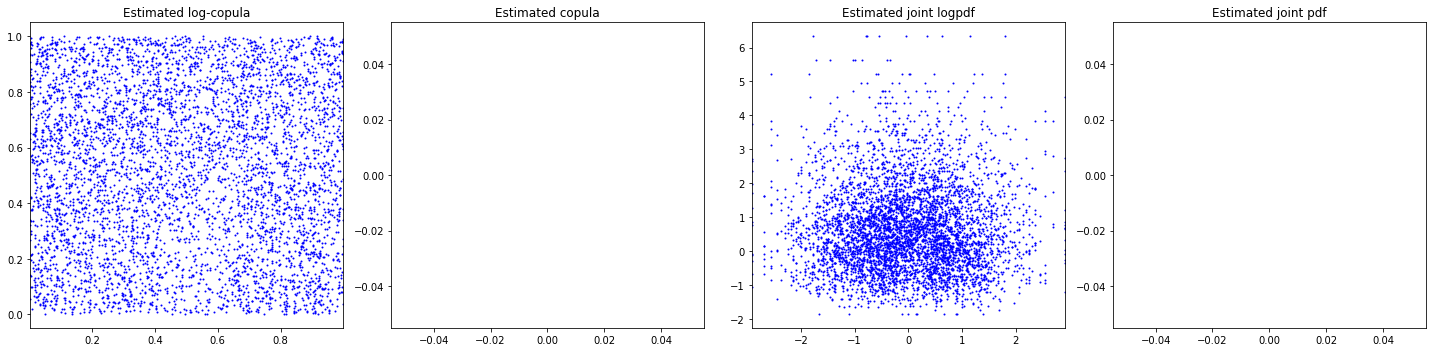

In [31]:
x_grid = np.linspace(min(transformed_samples_1), max(transformed_samples_1), 100)
y_grid = np.linspace(min(transformed_samples_2), max(transformed_samples_2), 100)
X, Y = np.meshgrid(x_grid, y_grid)

Z_q_x = scs.norm(loc=0,scale=1).logpdf(X)
Z_q_y = scs.gumbel_r.logpdf(Y)
Z_q = Z_q_x + Z_q_y
with torch.no_grad():
    ratio = mlp_Clayton.forward_simple(torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T).float()).detach().numpy()
Z_r = ratio.reshape(100,100)

U_x = scs.norm.cdf(X)
U_y = scs.gumbel_r.cdf(Y)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))


axs[0].contourf(U_x, U_y,Z_r, cmap='inferno',levels=100)
axs[0].set_title('Estimated log-copula')
axs[0].scatter(sample_x, sample_y, s=1, color='blue', label='data_p')

axs[1].contourf(U_x, U_y,np.clip(np.exp(Z_r),-1,np.quantile(np.exp(Z_r),0.98)), cmap='inferno',levels=100)
axs[1].set_title('Estimated copula')

axs[2].contourf(X, Y,Z_r-Z_q, cmap='inferno',levels=100)
axs[2].set_title('Estimated joint logpdf')
axs[2].scatter(transformed_samples_1, transformed_samples_2, s=1, color='blue', label='data_p')

axs[3].contourf(X, Y,np.clip(np.exp(Z_r-Z_q),-1,np.quantile(np.exp(Z_r-Z_q),0.8)), cmap='inferno',levels=50)
axs[3].set_title('Estimated joint pdf')     
plt.tight_layout()
plt.show()